## Visualization of CNN: Grad-CAM
* **Objective**: Convolutional Neural Networks are widely used on computer vision. It is powerful for processing grid-like data. However we hardly know how and why it works, due to the lack of decomposability into individually intuitive components. In this assignment, we use Grad-CAM, which highlights the regions of the input image that were important for the neural network prediction.


* NB: if `PIL` is not installed, try `conda install pillow`.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, datasets, transforms
import matplotlib.pyplot as plt
import pickle
import urllib.request
import cv2

import numpy as np
from PIL import Image

%matplotlib inline

### Download the Model
We provide you a pretrained model `ResNet-34` for `ImageNet` classification dataset.
* **ImageNet**: A large dataset of photographs with 1 000 classes.
* **ResNet-34**: A deep architecture for image classification.

In [3]:
resnet34 = models.resnet34(pretrained=True)
resnet34.eval() # set the model to evaluation mode

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

![ResNet34](https://miro.medium.com/max/1050/1*Y-u7dH4WC-dXyn9jOG4w0w.png)


Input image must be of size (3x224x224). 

First convolution layer with maxpool. 
Then 4 ResNet blocks. 

Output of the last ResNet block is of size (512x7x7). 

Average pooling is applied to this layer to have a 1D array of 512 features fed to a linear layer that outputs 1000 values (one for each class). No softmax is present in this case. We have already the raw class score!

In [4]:
classes = pickle.load(urllib.request.urlopen('https://gist.githubusercontent.com/yrevar/6135f1bd8dcf2e0cc683/raw/d133d61a09d7e5a3b36b8c111a8dd5c4b5d560ee/imagenet1000_clsid_to_human.pkl'))

## classes is a dictionary with the name of each class 


### Input Images
We provide you 20 images from ImageNet (download link on the webpage of the course or download directly using the following command line,).<br>
In order to use the pretrained model resnet34, the input image should be normalized using `mean = [0.485, 0.456, 0.406]`, and `std = [0.229, 0.224, 0.225]`, and be resized as `(224, 224)`.

In [5]:
def preprocess_image(dir_path):
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

    dataset = datasets.ImageFolder(dir_path, transforms.Compose([
            transforms.Resize(256), 
            transforms.CenterCrop(224), # resize the image to 224x224
            transforms.ToTensor(), # convert numpy.array to tensor
            normalize])) #normalize the tensor

    return (dataset)

In [6]:
# The images should be in a *sub*-folder of "data/" (ex: data/TP2_images/images.jpg) and *not* directly in "data/"!
# otherwise the function won't find them

import os
# os.mkdir("data")
# os.mkdir("data/TP2_images")
# !cd data/TP2_images && wget "https://www.lri.fr/~gcharpia/deeppractice/2023/TP2/TP2_images.zip" && unzip TP2_images.zip
dir_path = "data/" 
dataset = preprocess_image(dir_path)

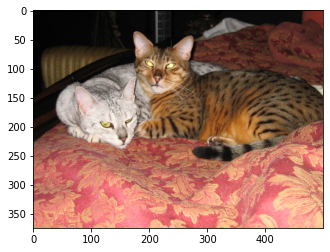

In [7]:
# show the orignal image 
index = 5
input_image = Image.open(dataset.imgs[index][0]).convert('RGB')
plt.imshow(input_image)

In [8]:
output = resnet34(dataset[index][0].view(1, 3, 224, 224))
values, indices = torch.topk(output, 3)
print("Top 3-classes:", indices[0].numpy(), [classes[x] for x in indices[0].numpy()])
print("Raw class scores:", values[0].detach().numpy())

Top 3-classes: [285 281 282] ['Egyptian cat', 'tabby, tabby cat', 'tiger cat']
Raw class scores: [13.077123  10.977326  10.5543785]


In [9]:
224/7

32.0

### Grad-CAM 
* **Overview:** Given an image, and a category (‘tiger cat’) as input, we forward-propagate the image through the model to obtain the `raw class scores` before softmax. The gradients are set to zero for all classes except the desired class (tiger cat), which is set to 1. This signal is then backpropagated to the `rectified convolutional feature map` of interest, where we can compute the coarse Grad-CAM localization (blue heatmap).


* **To Do**: Define your own function Grad_CAM to achieve the visualization of the given images. For each image, choose the top-3 possible labels as the desired classes. Compare the heatmaps of the three classes, and conclude. 


* **To be submitted within 2 weeks**: this notebook, **cleaned** (i.e. without results, for file size reasons: `menu > kernel > restart and clean`), in a state ready to be executed (if one just presses 'Enter' till the end, one should obtain all the results for all images) with a few comments at the end. No additional report, just the notebook!


* **Hints**: 
 + We need to record the output and grad_output of the feature maps to achieve Grad-CAM. In pytorch, the function `Hook` is defined for this purpose. Read the tutorial of [hook](https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html#forward-and-backward-function-hooks) carefully. 
 + The pretrained model resnet34 doesn't have an activation function after its last layer, the output is indeed the `raw class scores`, you can use them directly. 
 + The size of feature maps is 7x7, so your heatmap will have the same size. You need to project the heatmap to the resized image (224x224, not the original one, before the normalization) to have a better observation. The function [`torch.nn.functional.interpolate`](https://pytorch.org/docs/stable/nn.functional.html?highlight=interpolate#torch.nn.functional.interpolate) may help.  
 + Here is the link of the paper [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/pdf/1610.02391.pdf)

Class: ‘pug, pug-dog’ | Class: ‘tabby, tabby cat’
- | - 
![alt](https://raw.githubusercontent.com/jacobgil/pytorch-grad-cam/master/examples/dog.jpg)| ![alt](https://raw.githubusercontent.com/jacobgil/pytorch-grad-cam/master/examples/cat.jpg)

# Diagnitizing the archetecture of resnet34

In [163]:
def Grad_Cam(image, target, PIL_image, return_heatmap = True):

    resnet34 = models.resnet34(pretrained=True)
    resnet34.eval()

    # hook for output 
    def output_hook(model, input, output):
        return outputs.append(output.data)
    
    # hook for grad_output 
    def grad_hook(model, grad_input , grad_output):
        return gradients.append(grad_output[0])
    
    # let's store tha gradients, output of the layer of interest 

    gradients = []
    outputs = []

    # hook the last layer 
    gradients_hook = resnet34.layer4[2].bn2.register_backward_hook(grad_hook)
    outputs_hook = resnet34.layer4[2].bn2.register_forward_hook(output_hook)

    predictions = resnet34(image.view(1, 3, 224, 224))

    # next step is to create a variable to keep only the output of the concerned target class and track its gradient
    
    # to redo using signal solution to keep the structure of a neural net
    class_output = np.zeros((1, 1000), dtype= float)
    class_output[0, target] = 1
    class_output = torch.from_numpy(class_output).requires_grad_(True)
    class_output = torch.sum(class_output * predictions)
    
    # backpropagation
    resnet34.zero_grad()
    class_output.backward()

    
    
    # Now let's get the gradients and outputs*
    
    gradients = gradients[0][0].numpy()
    outputs = outputs[0][0].numpy()

    alphas = gradients.mean(axis = (1,2)) # get the alph for each feature
    # heatmap = sum(alphas * outputs[0, :, :]).detach()
    print(outputs.shape)
    heatmap = np.zeros((7, 7)) 

   # clip the heatmap
    

    # Compute heatmap 
    for i in range(alphas.shape[0]): 
        heatmap += alphas[i] * outputs[i, :, :]

    heatmap = np.where(heatmap >0, heatmap, 0)
    
    # remove hooks 
    gradients_hook.remove()
    outputs_hook.remove()

    heatmap = torch.from_numpy(heatmap.reshape(1,1,7,7))

    
    # let's resize the image 
    heatmap = F.interpolate(heatmap.reshape(1,1, 7, 7), scale_factor= 224//7,mode= 'bilinear').numpy()[0,0, :, :]

    

    heatmap = heatmap / np.max(heatmap) # to have values in the range 0,1

    heatmap = (heatmap * 255 ).astype(np.uint8)

    heatmap = np.array(cv2.applyColorMap(heatmap, cv2.COLORMAP_JET), dtype= float)

    PIL_image =np.array(Image.open(PIL_image).convert('RGB').resize((224, 224)), dtype= float)

    image = (heatmap / 255) * 0.5 + 0.5 * (PIL_image / 255)
    
    image = (255 * image[:, :, ::-1]).astype(np.uint8)
    
    if return_heatmap:
        return image, heatmap
    else:
        return image

In [ ]:
import matplotlib.pyplot as plt 
plt.plot([i for i in range(10)])

In [142]:
################
## Grad Cam
################
def Grad_Cam(image,category):

  # Useful functions to extract gradients and features 
  def _backward_hook(model, grad_input, grad_output):
    gradients.append(grad_output[0])

  def _forward_hook(model, input, output):
    features.append(output.data)

  features = []
  gradients = []

  # Hooks for the gradients and features 
  hook1 = model.layer4[2].bn2.register_backward_hook(_backward_hook)
  hook2 = model.layer4[2].bn2.register_forward_hook(_forward_hook)
  
  # Extract last predicted layer 
  output = model(image)

  # Create signal 
  signal = np.zeros((1, output.size()[-1]), dtype=np.float32)
  signal[0][category] = 1
  signal = torch.from_numpy(signal).requires_grad_(True)
  signal = torch.sum(signal * output)

  # Backpropagate signal
  model.zero_grad()
  signal.backward(retain_graph=True) 

  # Extract gradients and features 
  
  gradients = gradients[0][-1].numpy()
  features = features[0][-1].numpy()
  
  # Compute weights using gradients 
  Weights = np.mean(gradients, axis=(1,2))
  
  # Initiate a heatmap
  heatmap = np.zeros(features.shape[1:]) 

  # Remove Hooks 
  hook1.remove()
  hook2.remove()

  # Compute heatmap 
  for i in range(Weights.shape[0]): 
      heatmap += Weights[i] * features[i, :, :]

  # ReLU on top of the heatmap
  heatmap = np.maximum(heatmap, 0) 

  # Interpolate values 
  heatmap = torch.from_numpy(heatmap.reshape(1,1,7,7))
  heatmap = F.interpolate(heatmap,scale_factor=32,mode='bilinear')
  heatmap = heatmap.numpy()[0,0,:,:]

  # Normalize the heatmap
  heatmap = heatmap / np.max(heatmap)

  return heatmap


################
# Combine an image with its heatmap
################
def apply_heatmap(img, map):

  # Construct a map
  heatmap = cv2.applyColorMap(np.uint8(255*map), cv2.COLORMAP_JET) 
  heatmap = np.float32(heatmap)/255

  # Merge the image with its map  
  merged_image = cv2.addWeighted(heatmap, 0.5, img, 0.5, 0.0)
  merged_image = np.uint8(255*merged_image[:, :, ::-1])

  return merged_image

In [157]:
alphas = Grad_Cam(dataset[index][0], 285, dataset.imgs[index][0], True)

c:\Users\zakar\anaconda3\envs\deep_learning_iot\lib\site-packages\torch\nn\functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


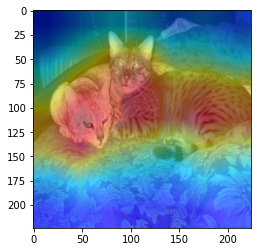

In [158]:
plt.imshow(alphas[0])

In [156]:
dataset[index][1]

0

In [143]:
heatmap = Grad_Cam(input, category)

array([285, 281, 282], dtype=int64)

c:\Users\zakar\anaconda3\envs\deep_learning_iot\lib\site-packages\torch\nn\functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


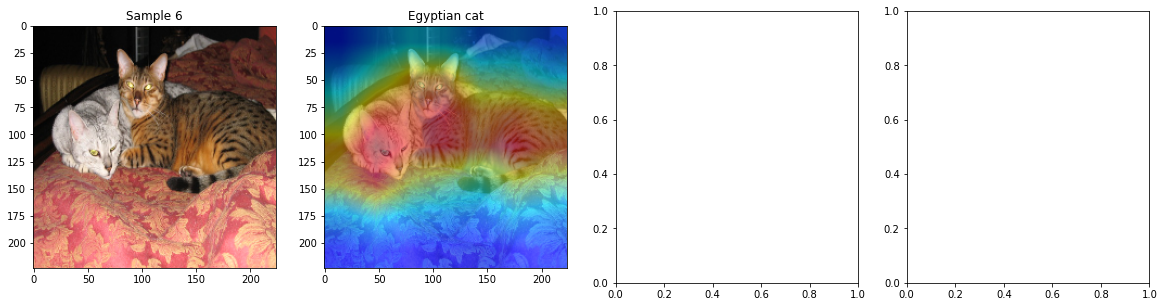

In [117]:
for i in range(index, index + 1):
      
  img = np.array(Image.open(dataset.imgs[i][0]).convert('RGB'))
  img = np.float32(cv2.resize(img, (224, 224))) / 255
  input = dataset[i][0].view(1, 3, 224, 224)

  model = models.resnet34(pretrained=True)
  model.eval()

  output = model(input)
  values, indices = torch.topk(output,3)

  f, ax = plt.subplots(1,4,figsize=(20,5))
  ax[0].imshow(img)
  ax[0].set_title('Sample '+str(i+1))
  for j in range(1,2): 

    category = indices[0].numpy()[j-1]
    heatmap = Grad_Cam(input, category)
    merged_img = apply_heatmap(img,heatmap)
    ax[j].imshow(merged_img)
    names = classes[category].split(',') 
    ax[j].set_title(names[0])

  plt.show()